# MARINe/PISCO: Intertidal: MARINe Coastal Biodiversity Surveys: Swath Surveys Summarized - DarwinCore conversion

**Marine Lebrec, April 2024** <br>
This dataset was mobilized as part of the 2024 Marine Biological Data Mobilization Workshop <br>

**Useful Links**:
- [Published dataset on DataONE](https://data.piscoweb.org/metacatui/view/doi:10.6085/AA/marine_cbs.11.6)
- [Github issue for this dataset](https://github.com/ioos/bio_data_guide/issues/244)
- [2024 Marine Bio Data Workshop materials](https://ioos.github.io/bio_mobilization_workshop/)
- [NERC vocabulary server](https://vocab.nerc.ac.uk/collection/)

**Dataset Description**:
This metadata record documents the Swath surveys for the MARINe Biodiversity Surveys. Biodiversity surveys are comprised of four components, all sampled along the same transects: (1) point contact estimates of intertidal cover and substrate characteristics, (2) swath transects to estimate the density of seastars and abalone, (3) quadrat sampling to estimate the density of mobile invertebrates, and (4) topography (elevation relative to mean low low water (mllw)). Selected sites are resampled on a 3-5 year cycle. A site is defined as a contiguous rocky bench of at least 30m. Swath sampling consists of recording the number of seastars and abalone on eleven 2m wide transects of variable length extending from the upper intertidal to the low intertidal.

**Sampling Description**: Swath sampling consists of recording the number of seastars and other large invertebrates in a two meter wide band centered over each transect. The location (to the nearest half meter along the transect), number, and species names are recorded. Intertidal surveys are comprised of four components, all sampled along the same transects: (1) point contact estimates of intertidal cover and substrate characteristics, (2) swath transects to estimate the density of seastars and abalone, (3) quadrat sampling to estimate the density of mobile invertebrates, and (4) topography (elevation relative to mean low low water (mllw)). <br>

This notebook was generated in the [Research Workspace](https://www.researchworkspace.com/intro/). All updates to this notebook are made there.

In [1]:
## Imports 

from datetime import date, datetime
import os
import numpy as np
import pandas as pd
import pyworms
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
## ----- ENTER VERSION NUMBER HERE -----

version = '11_7'

## Get directory info

folder = os.path.join('resourceMap_marine_cbs_' + version, 'data')
filenames = [file for file in os.listdir(folder) if file.endswith('.txt') or file.endswith('.csv')]
filenames.sort()
filenames

['doi_10.6085_AA_marine_cbs.12.2-DATA.txt',
 'doi_10.6085_AA_marine_cbs.7.2-DATA.txt',
 'marine_site_table.csv',
 'swath_data_CORRECTED.csv']

In [3]:
## Load data

data = pd.read_csv(os.path.join(folder, filenames[3]))
print(data.shape)

species = pd.read_csv(os.path.join(folder, filenames[1]))
print(species.shape)

site = pd.read_csv(os.path.join(folder, filenames[2]))
print(site.shape)

(11358, 22)
(739, 14)
(274, 17)


In [4]:
# Let's take a look at all of the column in this data table 
data.columns

Index(['marine_site_name', 'site_code', 'latitude', 'longitude', 'survey_rep',
       'year', 'Min(sample_date)', 'Max(sample_date)', 'species_lump',
       'total_count', 'number_of_transects_sampled',
       'est_swath_area_searched_m2', 'density_per_m2', 'state_province',
       'georegion', 'bioregion', 'mpa_designation', 'mpa_region',
       'mpa_lt_region', 'mpa_name', 'island', 'last_updated'],
      dtype='object')

#### Overview of DwC schema: 
I'll be using an event core with occurrence and EMOF extensions. More information on when to use an Event Core schema count be [found here](https://manual.obis.org/formatting.html#when-to-use-event-core).<br>

Descriptions of terms used in each table are listed here:

**Event-level information:**
- eventDate: This information is included in the data table and will be defined as the time span between the minimum and maximum time that a site was surveyed during a single visit. 
- eventID: A unique ID will be built containing the site code + start/end dates, all provided from data table.
- decimalLatitude / decimalLongitude: site coordinates are included in the site table 
- samplingProtocol: I will include a link to the MARINe protocols website 
- locality: The name of each site (marine_site_name) provided in the site table.  
- county: This information is also provided in the site table.
- stateProvince: This information is also provided in the site table.
- countryCode: This information is also provided in the site table.
- geodeticDatum: WSG84 

**Occurrence-level information:**
- occurrenceID: A unique identifier will be generated, derived from eventID with cumcount to make each occurrence from an event unique. 
- scientificName and other WoRMS fields: Species information and aphidIDs are included in the species table. I will re-run the species table through pyworms to identify any missing pieces. 
- organismQuantity: The total_count for each scientificName, provided from data table
- organismQuantityType: The type of counts, in this case we will use "individuals". 

**EMOF information:**
- MeasurementValue: In addition to individual counts, the organism densities were estimated using the estimated swath area searched (density_per_m2 from the data table). I will also include the swath area as a measurement in this table, from the est_swath_area_searched_m2 from the data table.
- MeasurementUnit, measurementUnitID: controlled vocabularies describing the units for organism density and survey area. 
- MeasurementType, measurementTypeID: controlled vocabularies describing the types of measurements for organism density and survey area. 

#### I'll start by making an occurrence table which contains all of the event-level and occurrence level information, since the main data table contains rows of occurrences. Further down, I'll use this main occ table to create the event core and extension tables.

In [5]:
# create a dataframe w/ eventIDs
occ = pd.DataFrame({'eventID':data['site_code'].astype(str) + '_' + 
                    data['Min(sample_date)'] + '_' + 
                    data['Max(sample_date)']})

## eventDate
occ['eventDate'] = data['Min(sample_date)'] + '/' + data['Max(sample_date)']

# datasetName
occ['datasetName'] = 'MARINe CBS - Swath Surveys Summarized'

# basisOfRecord 
occ['basisOfRecord'] = 'HumanObservation'

# geodeticDatum
occ['geodeticDatum'] = 'WGS84'

# Depth
occ['minimumDepthInMeters'] = 0
occ['maximumDepthInMeters'] = 0

# samplingProtocol
occ['samplingProtocol'] = 'cbs swath transects https://marine.ucsc.edu/methods/biodiversity-methods.html#bio-method-swath'

# coordinateUncertaintyInMeters
occ['coordinateUncertaintyInMeters'] = 350

# occurrenceRemarks - leave empty for now until occ extension is made
occ['occurrenceRemarks'] = ''

occ.head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,occurrenceRemarks
0,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,
1,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,


In [6]:
## QC test to make sure all marine_site_name unique values in the data table are also in the site table

if set(data['marine_site_name'].unique()).issubset(set(site['marine_site_name'].unique())):
    print("All unique values of data['marine_site_name'] are in sites['marine_site_name']")
else:
    print("Not all unique values of data['marine_site_name'] are in sites['marine_site_name']")


All unique values of data['marine_site_name'] are in sites['marine_site_name']


In [7]:
## merge occurence table with site table to get coordinate locations, county, stateProvince, countryCode, decimalLat, decimalLon

occ['marine_site_name'] = data['marine_site_name']

## define columns to merge from site table
site_cols = [
    'marine_site_name',
    'county',
    'state_province',
    'country',
    'latitude',
    'longitude',
    'mpa_name'
]

## merge
occ = occ.merge(site[site_cols], how='left', on='marine_site_name')

In [8]:
## define DwC terms for these columns after merge
dwc_cols = [
    'eventID',
    'eventDate',
    'datasetName',
    'basisOfRecord',
    'geodeticDatum',
    'minimumDepthInMeters',
    'maximumDepthInMeters',
    'samplingProtocol',
    'coordinateUncertaintyInMeters',
    'occurrenceRemarks',
    'locality',
    'county',
    'stateProvince',
    'countryCode',
    'decimalLatitude',
    'decimalLongitude',
    'locationRemarks'
]

## change column names to DwC
occ.columns = dwc_cols 

In [9]:
## take a look at the updated occ table
occ.head(3)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,occurrenceRemarks,locality,county,stateProvince,countryCode,decimalLatitude,decimalLongitude,locationRemarks
0,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,,Cat Rock,Ventura,California,United States,34.005569,-119.41925,Anacapa Island Special Closure
1,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,,Cat Rock,Ventura,California,United States,34.005569,-119.41925,Anacapa Island Special Closure
2,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,,Cat Rock,Ventura,California,United States,34.005569,-119.41925,Anacapa Island Special Closure


In [10]:
## update locationRemarks w/ more descriptive text related to if the site is within or outside of an MPA.

for index, row in occ.iterrows():
    if row['locationRemarks'] != "NONE":
        occ.at[index, 'locationRemarks'] = "This site is inside of a Marine Protected Area: " + row['locationRemarks']
        
occ.loc[occ.locationRemarks == 'NONE', ['locationRemarks']] = 'This site is outside of a Marine Protected Area.'

In [11]:
## dwc:county is not available for non-US sites. Change "Not Applicable" to empty strings. 

occ.loc[occ['county'] == 'Not Applicable', 'county'] = ''

In [12]:
## add ISO 3166-1-alpha-2 country code to dwc:countryCode - https://www.iso.org/obp/ui/#search 

occ['countryCode'] = occ['countryCode'].replace({'United States': 'US',
                                                 'Mexico': 'MX',
                                                 'Canada': 'CA'})

In [13]:
## occurrenceID (eventID + count number of occurence along a transect) 

occ['occurrenceID'] = data.groupby(['site_code', 
                                    'Min(sample_date)', 
                                    'Max(sample_date)'])['species_lump'].cumcount()+1


occ['occurrenceID'] = occ['eventID'] + '_' + occ['occurrenceID'].astype(str)

# make sure all occurrenceIDs are unique
len(occ['occurrenceID'].unique()), len(occ)

(11358, 11358)

In [14]:
## organismQuantity
occ['organismQuantity'] = data['total_count']

## organismQuantityType
occ['organismQuantityType'] = 'individuals'

## occurrenceStatus
occ['occurrenceStatus'] = ''
occ.loc[occ.organismQuantity == 0.0, ['occurrenceStatus']] = 'absent'
occ.loc[occ.organismQuantity > 0.0, ['occurrenceStatus']] = 'present'

In [15]:
## add columns to occ table that will be used for the EMOF extension.
## note that the column names will be changed in the eMOF table (they are not using DwC terms yet)

occ['measurementValue_density'] = data['density_per_m2']
occ['measurementValue_area'] = data['est_swath_area_searched_m2']

In [16]:
occ.head(2)

,eventID,eventDate,datasetName,basisOfRecord,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,coordinateUncertaintyInMeters,occurrenceRemarks,...,countryCode,decimalLatitude,decimalLongitude,locationRemarks,occurrenceID,organismQuantity,organismQuantityType,occurrenceStatus,measurementValue_density,measurementValue_area
0,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,,...,US,34.005569,-119.41925,This site is inside of a Marine Protected Area...,400_2001-10-18_2001-10-18_1,0,individuals,absent,0.0,379.8
1,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,MARINe CBS - Swath Surveys Summarized,HumanObservation,WGS84,0,0,cbs swath transects https://marine.ucsc.edu/me...,350,,...,US,34.005569,-119.41925,This site is inside of a Marine Protected Area...,400_2001-10-18_2001-10-18_2,0,individuals,absent,0.0,379.8


## Using pyworms to access the WoRMS database for scientificName information

In [17]:
## scientificName
occ['scientificName'] = data['species_lump']

There are 2 species in the dataset that are in the species table, but not listed as being a "swath" primary_survey_type. <br>
Rani Gaddam confirmed that "since these species are smaller the swath surveys are not appropriate for determining abundance, so we use the quadrat surveys for those species." To handle the fact that there are 2 samplingProtocols used in this dataset, I decided to do the following:
- For sites where either Leptasterias spp or Ophiuroid were observed, change the samplingProtocol to include links to both the swath transect and the quadrat protocols. 
- For additional granularity, I specified ifan occurrence used quadrats vs swath surveys in the occurrenceRemarks depending on the scientificName. 


In [18]:
species_swath = species[species['primary_survey_type'] == 'swath']

print('Species which do not use swath transects as its primary sampling type:\n')
for i in data['species_lump'].unique():
    if len(species_swath[species_swath['species_lump'] == i]) == 0:
        print(i)

Species which do not use swath transects as its primary sampling type:

Leptasterias spp
Ophiuroid


In [19]:
## based on pyworms query (below), make manual changes where outputs showed no match:

## Ophiuroidea
occ.loc[occ.scientificName == 'Ophiuroid', ['scientificName']] = 'Ophiuroidea'

In [20]:
## samplingProtocol
occ.loc[occ['scientificName'].str.contains('Leptasterias spp|Ophiuroidea'), 'samplingProtocol'] = 'cbs swath transects https://marine.ucsc.edu/methods/biodiversity-methods.html#bio-method-swath | cbs quadrat surveys https://marine.ucsc.edu/methods/biodiversity-methods.html#bio-method-quad'

In [21]:
## run pyworms query
## this code is adapted from an IOOS notebook (https://ioos.github.io/ioos_code_lab/content/code_gallery/data_management_notebooks/2020-12-08-DataToDwC.html)
## print statements can be uncommented as needed

for index, row in occ.iterrows():
    resp = pyworms.aphiaRecordsByMatchNames(row['scientificName'], marine_only=True)
    
    # When no matches are found, print the non-matching name and move on
    if len(resp[0]) == 0:
        #print('\nNo match for name "{}"'.format(row['scientificName']))
        continue
        
    # When more than 1 match is found, the user needs to take a look. But tell the user which one has multiple matches
    elif len(resp[0]) > 1:
       # print('\nMultiple matches for name "{}":'.format(row['scientificName']))
        #pprint.pprint(resp[0], indent=4)
        continue
    
    else:
        # When only 1 match is found, put the appropriate information into the appropriate row and column
        worms = resp[0][0]
        occ.loc[index, 'scientificNameID'] = worms['lsid']
        occ.loc[index, 'taxonRank'] = worms['rank']
        occ.loc[index, 'match_type'] = worms['match_type']

In [22]:
# run a quick test to make sure that the scientificNameIDs generated from the pyworms query are consistent
# with the IDs provided in the species table. 

occ.rename(columns = {'scientificName':'species_lump'}, inplace=True) #change column name for merging 

sp_cols = ['species_lump', 
          'taxonomic_id',
          'kingdom',
          'phylum',
          'class',
          'order',
          'family',
          'genus',
          'species']

occ = occ.merge(species[sp_cols], how='left', on='species_lump')

occ['scientificNameID_split'] =  occ['scientificNameID'].str.split(':').str[4]
occ['taxonomic_id'] = occ['taxonomic_id'].astype(str).str.split('.').str[0]

ids_unmatched = []
for index, row in occ.iterrows():
    if row['taxonomic_id'] != row['scientificNameID_split']:
        ids_unmatched.append(row['species_lump'])
print('inconsistent IDs for:', np.unique(ids_unmatched))

inconsistent IDs for: ['Echinaster spp' 'Ophiuroidea']


In [23]:
# make sure Ophiuroid from species table matches Ophiuroidea from WoRMS output

print('WoRMS query scientificNameID for Ophiuroidea (from pyworms query):', occ[occ['species_lump'] == 'Ophiuroidea'].scientificNameID_split.unique())
print('WoRMS query scientificNameID for Ophiuroid (from species table):', species[species['species_lump'] == 'Ophiuroid'].taxonomic_id.unique())

WoRMS query scientificNameID for Ophiuroidea (from pyworms query): ['123084']
WoRMS query scientificNameID for Ophiuroid (from species table): [123084.]


In [24]:
# make sure that the WoRMS ID for Echinaster spp is correct
# manual check confirms the ID is correct: https://www.marinespecies.org/aphia.php?p=taxdetails&id=123275 

print('WoRMS query scientificNameID for Echinaster spp:', occ[occ['species_lump'] == 'Echinaster spp'].scientificNameID_split.unique())
print('WoRMS query scientificNameID for Echinaster spp (from species table):', species[species['species_lump'] == 'Echinaster spp'].taxonomic_id.unique())

WoRMS query scientificNameID for Echinaster spp: [nan]
WoRMS query scientificNameID for Echinaster spp (from species table): [123275.]


In [25]:
# now that we validated that the taxonomic_id column of the species table is consistent with the WoRMS query,
# we can be confident that the information in the species table can be used to populate the occurrence table.
# we no longer need the match_type, and scientificNameID_split, scientificNameID columns

occ.drop(columns = [
          'match_type',
          'scientificNameID_split',
          'scientificNameID'
                   ], inplace=True)

In [26]:
# rename several columns to DwC terms

occ.rename(columns = {
    'species_lump':'scientificName',
    'taxonomic_id':'scientificNameID'
}, inplace=True)

In [27]:
# make the scientificNameID include the entire 'urn:lsid:marinespecies.org:taxname:' string

occ['scientificNameID'] = 'urn:lsid:marinespecies.org:taxname:' + occ['scientificNameID'].astype(str)
occ['scientificNameID'][0]

'urn:lsid:marinespecies.org:taxname:255044'

In [28]:
# manually add in taxonomic information for Ophiuroidea since it did not have an exact pyworms match

occ.loc[occ.scientificName == 'Ophiuroidea', ['taxonRank',
                                              'scientificNameID',
                                              'kingdom',
                                              'phylum',
                                              'class',
                                              'order',
                                              'family', 
                                              'genus',
                                              'species']] = 'Class','urn:lsid:marinespecies.org:taxname:123084', 'Animalia', 'Echinodermata', 'Ophiuroidea', '', '', '', ''

In [29]:
# manually add in taxonRank information for Echinaster spp since it did not have an exact pyworms match

occ.loc[occ.scientificName == 'Echinaster spp', ['taxonRank']] = 'Genus'

In [30]:
# convert nan values to empty strings, which is preferred for a Darwin Core Archive.

occ.loc[pd.isna(occ['species']), 'species'] = ''

In [31]:
# Check for any additional nan values in other columns 
occ.isna().sum()

eventID                          0
eventDate                        0
datasetName                      0
basisOfRecord                    0
geodeticDatum                    0
minimumDepthInMeters             0
maximumDepthInMeters             0
samplingProtocol                 0
coordinateUncertaintyInMeters    0
occurrenceRemarks                0
locality                         0
county                           0
stateProvince                    0
countryCode                      0
decimalLatitude                  0
decimalLongitude                 0
locationRemarks                  0
occurrenceID                     0
organismQuantity                 0
organismQuantityType             0
occurrenceStatus                 0
measurementValue_density         0
measurementValue_area            0
scientificName                   0
taxonRank                        0
scientificNameID                 0
kingdom                          0
phylum                           0
class               

## Make Event Core

In [33]:
# pull necessary columns from occurrence table

event = occ[['eventID', 
             'eventDate', 
             'decimalLatitude', 
             'decimalLongitude', 
             'locality', 
             'county', 
             'stateProvince', 
             'countryCode', 
             'geodeticDatum', 
             'minimumDepthInMeters', 
             'maximumDepthInMeters',
             'coordinateUncertaintyInMeters',
             'samplingProtocol',
             'datasetName',
             'locationRemarks']].copy()

event.drop_duplicates(inplace=True)
event = event[event['samplingProtocol'] == 'cbs swath transects https://marine.ucsc.edu/methods/biodiversity-methods.html#bio-method-swath | cbs quadrat surveys https://marine.ucsc.edu/methods/biodiversity-methods.html#bio-method-quad']
event.reset_index(inplace=True,drop=True)
event.head(3)


,eventID,eventDate,decimalLatitude,decimalLongitude,locality,county,stateProvince,countryCode,geodeticDatum,minimumDepthInMeters,maximumDepthInMeters,coordinateUncertaintyInMeters,samplingProtocol,datasetName,locationRemarks
0,400_2001-10-18_2001-10-18,2001-10-18/2001-10-18,34.005569,-119.41925,Cat Rock,Ventura,California,US,WGS84,0,0,350,cbs swath transects https://marine.ucsc.edu/me...,MARINe CBS - Swath Surveys Summarized,This site is inside of a Marine Protected Area...
1,6009_2015-06-02_2015-06-02,2015-06-02/2015-06-02,39.569065,-123.77182,Abalobadiah Creek,Mendocino,California,US,WGS84,0,0,350,cbs swath transects https://marine.ucsc.edu/me...,MARINe CBS - Swath Surveys Summarized,This site is inside of a Marine Protected Area...
2,6009_2018-07-13_2018-07-13,2018-07-13/2018-07-13,39.569065,-123.77182,Abalobadiah Creek,Mendocino,California,US,WGS84,0,0,350,cbs swath transects https://marine.ucsc.edu/me...,MARINe CBS - Swath Surveys Summarized,This site is inside of a Marine Protected Area...


In [34]:
# either Leptasterias spp or Ophiuroidea were observed at each event, which is why we should only include events with both sampling protocols (quadrats and swaths). 
occ.groupby('eventID')['samplingProtocol'].nunique().unique()

array([2])

In [35]:
# Make sure that all eventIDs in event core are unique 
len(event.eventID.unique()), len(event), len(occ.eventID.unique())

(631, 631, 631)

In [37]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'event_core_' + today + '.csv'

event.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

## Make Occurrence Extension

In [38]:
# pull necessary columns from occurrence table

occ_ext = occ[['eventID', 
               'occurrenceID', 
               'basisOfRecord', 
               'scientificName', 
               'scientificNameID', 
               'occurrenceStatus',
               'organismQuantity',
               'organismQuantityType',
               'kingdom', 
               'taxonRank', 
               'kingdom',
               'phylum',
               'class',
               'order',
               'family',
               'genus',
               'species',
               'occurrenceRemarks']].copy()

In [40]:
# Add in occurrenceRemarks specifying that unless the species is Ophiuroidea or Leptasterias spp, swath surveys are used. 

occ_ext['occurrenceRemarks'] = 'Swath surveys are used to estimate abundance for this organism.'
occ_ext.loc[occ_ext.scientificName == 'Leptasterias spp', ['occurrenceRemarks']] = 'Quadrat surveys are used to estimate abundance for this organism.'
occ_ext.loc[occ_ext.scientificName == 'Ophiuroidea', ['occurrenceRemarks']] = 'Quadrat surveys are used to estimate abundance for this organism.'

In [41]:
occ_ext.head(3)

,eventID,occurrenceID,basisOfRecord,scientificName,scientificNameID,occurrenceStatus,organismQuantity,organismQuantityType,kingdom,taxonRank,kingdom,phylum,class,order,family,genus,species,occurrenceRemarks
0,400_2001-10-18_2001-10-18,400_2001-10-18_2001-10-18_1,HumanObservation,Astrometis sertulifera,urn:lsid:marinespecies.org:taxname:255044,absent,0,individuals,Animalia,Species,Animalia,Echinodermata,Asteroidea,Forcipulatida,Asteriidae,Astrometis,Astrometis sertulifera,Swath surveys are used to estimate abundance f...
1,400_2001-10-18_2001-10-18,400_2001-10-18_2001-10-18_2,HumanObservation,Cryptochiton stelleri,urn:lsid:marinespecies.org:taxname:240776,absent,0,individuals,Animalia,Species,Animalia,Mollusca,Polyplacophora,Chitonida,Acanthochitonidae,Cryptochiton,Cryptochiton stelleri,Swath surveys are used to estimate abundance f...
2,400_2001-10-18_2001-10-18,400_2001-10-18_2001-10-18_3,HumanObservation,Dermasterias imbricata,urn:lsid:marinespecies.org:taxname:240771,absent,0,individuals,Animalia,Species,Animalia,Echinodermata,Asteroidea,Valvatida,Asteropseidae,Dermasterias,Dermasterias imbricata,Swath surveys are used to estimate abundance f...


In [42]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'occurence_extension_' + today + '.csv'

occ_ext.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

## Make Extended Measurement or Fact Extension

In [43]:
# pull necessary columns from occurrence table
# this dataframe contains density of organisms (counts per m2), which has occurrence level information

emof_density = occ[['occurrenceID', 
                    'eventID',
                    'measurementValue_density']].copy()
emof_density.rename(columns = {'measurementValue_density': 'measurementValue'}, inplace=True)

emof_density['measurementUnit'] = '#/m^2'
emof_density['measurementUnitID'] = 'http://vocab.nerc.ac.uk/collection/P06/current/UPMS/'
emof_density['measurementType'] = 'The number of an identified biological object described elsewhere in the metadata occurring in a given area of the seabed'
emof_density['measurementTypeID'] = 'http://vocab.nerc.ac.uk/collection/P09/current/ABB2/'


emof_density.head(2)

,occurrenceID,eventID,measurementValue,measurementUnit,measurementUnitID,measurementType,measurementTypeID
0,400_2001-10-18_2001-10-18_1,400_2001-10-18_2001-10-18,0.0,#/m^2,http://vocab.nerc.ac.uk/collection/P06/current...,The number of an identified biological object ...,http://vocab.nerc.ac.uk/collection/P09/current...
1,400_2001-10-18_2001-10-18_2,400_2001-10-18_2001-10-18,0.0,#/m^2,http://vocab.nerc.ac.uk/collection/P06/current...,The number of an identified biological object ...,http://vocab.nerc.ac.uk/collection/P09/current...


In [44]:
# pull necessary columns from occurrence table
# this dataframe contains estimated swath area searched, which has event level information

emof_area = occ[['eventID', 
                'measurementValue_area']].copy()
# add empty occurrenceID column for concatenation with emof_density
emof_area['occurrenceID'] = ''
emof_area.rename(columns = {'measurementValue_area': 'measurementValue'}, inplace=True)

emof_area['measurementUnit'] = 'm^2'
emof_area['measurementUnitID'] = 'https://vocab.nerc.ac.uk/collection/P06/current/UMSQ/'
emof_area['measurementType'] = 'The area of the seabed or shore observed or sampled - such as the area of a box core'
emof_area['measurementTypeID'] = 'http://vocab.nerc.ac.uk/collection/P09/current/ABED/'

emof_area.head()

,eventID,measurementValue,occurrenceID,measurementUnit,measurementUnitID,measurementType,measurementTypeID
0,400_2001-10-18_2001-10-18,379.8,,m^2,https://vocab.nerc.ac.uk/collection/P06/curren...,The area of the seabed or shore observed or sa...,http://vocab.nerc.ac.uk/collection/P09/current...
1,400_2001-10-18_2001-10-18,379.8,,m^2,https://vocab.nerc.ac.uk/collection/P06/curren...,The area of the seabed or shore observed or sa...,http://vocab.nerc.ac.uk/collection/P09/current...
2,400_2001-10-18_2001-10-18,379.8,,m^2,https://vocab.nerc.ac.uk/collection/P06/curren...,The area of the seabed or shore observed or sa...,http://vocab.nerc.ac.uk/collection/P09/current...
3,400_2001-10-18_2001-10-18,379.8,,m^2,https://vocab.nerc.ac.uk/collection/P06/curren...,The area of the seabed or shore observed or sa...,http://vocab.nerc.ac.uk/collection/P09/current...
4,400_2001-10-18_2001-10-18,379.8,,m^2,https://vocab.nerc.ac.uk/collection/P06/curren...,The area of the seabed or shore observed or sa...,http://vocab.nerc.ac.uk/collection/P09/current...


In [45]:
emof = pd.concat([emof_density, emof_area])

In [47]:
np.shape(emof)

(22716, 7)

In [48]:
## Save

today = date.today().strftime('%Y%m%d')
output_filename = 'emof_extension_' + today + '.csv'

emof.to_csv(os.path.join(os.getcwd()+'/processed/', output_filename), index=False)

## Data QA/QC

/opt/conda/envs/py39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/py39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/py39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/opt/conda/envs/py39/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


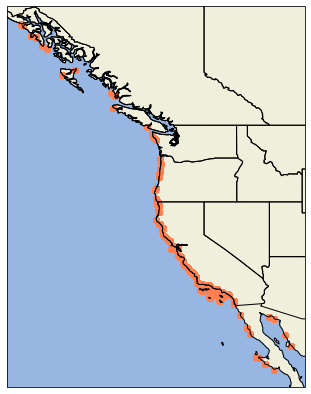

In [49]:
# Create map of data to check for any errors in coordinates - everything looks good!

plt.figure(figsize=[10,7])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.OCEAN)
plt.scatter(occ.decimalLongitude, occ.decimalLatitude, c='coral');

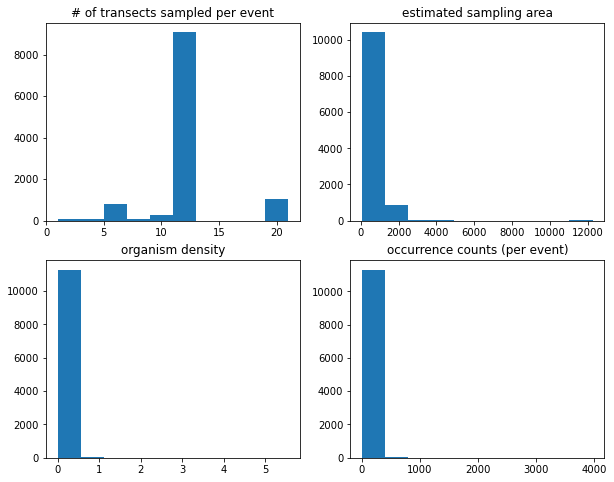

In [50]:
# basic histograms of the different measurements taken in this dataset

plt.figure(figsize=[10,8])
plt.subplot(2,2,1)
plt.title('# of transects sampled per event')
plt.hist(data.number_of_transects_sampled)
plt.subplot(2,2,2)
plt.title('estimated sampling area')
plt.hist(emof_area.measurementValue)
plt.subplot(2,2,3)
plt.title('organism density')
plt.hist(emof_density.measurementValue);
plt.subplot(2,2,4)
plt.title('occurrence counts (per event)')
plt.hist(occ_ext.organismQuantity);

In [51]:
# There was an event where 3969 pisasters were observed. 
occ_ext[occ_ext['organismQuantity'] == np.max(occ_ext.organismQuantity)]

# This translates to a reasonably organism density (5 individuals/m2)
data[data['total_count'] == 3969].density_per_m2 

10276    5.052833
Name: density_per_m2, dtype: float64

**Questions answered by Rani Gaddam (MARINe data manager):**
- The site_code field in the data and site tables are different (one is numeric, one is letters). I am using the marine_site_code which works fine but should the site_code fields be fixed? **For the other CBS dataset that was mobilized, Rani had confirmed that this is normal and my approach is good.** 


- I'm assuming it is still appropriate to use 350m as the coordinate uncertainty in meters? This was used in other datasets due to the fact that 350m is the maximum distance between any plots from the point locations. Just wanted to make sure that is still appropriate to use that value. **RG: Yes - that distance is still appropriate to use!**


- I noticed there were 2 species in the species table that were not listed as having the primary_survey_type equal to "swath" (Leptasterias spp and Ophiuroid). I assume that's not an issue, just wanted to flag it. **RG: Yes - that is correct - since they are smaller the swath surveys are not appropriate for determining abundance, so we use the quadrat surveys for those species**. Based on feedback that I got at the OBIS workshop: I will include both samplingProtocols in the event core, and specify further in the occurrenceRemarks. 


- The species_lump name "Ophiuroid" is not an accepted name in WoRMS so I changed it to "Ophiuroidea" which is the accepted name for the taxonomic_id that was provided in the species table. Just letting you know of this minor edit. **RG: That is fine!**


- I'm using the species_lump column from the data and species tables to get the taxonomic information. I just want to make sure that's the correct column to use as opposed to the final_classification column in the species table. It looks like the final_classification is basically the same as the species_lump, but all lowercase and slightly different syntax. I'll continue using the species_lump as that was your preference in the past and species_lump uses the proper capitalization based on what WoRMS prefers, but just wanted to make sure that's good with you. **RG: Yes - the species_lump is what should be used**

**Questions answered during workshop**
- How to hanlde multiple types of sampling - recommendation was to mention this information in samplingProtocol (event table) and occurrenceRemarks (occurrence extension table).